In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
print(os.listdir("."))

# Any results you write to the current directory are saved as output.

['creditcard.csv']
['.ipynb_checkpoints', '__notebook_source__.ipynb']


cuda


In [26]:
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


Text(0,0.5,'Frequency')

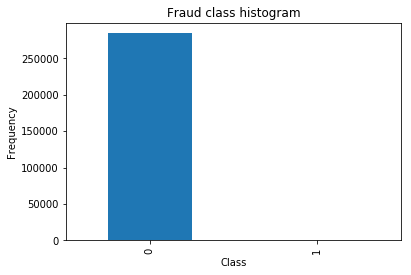

In [19]:
# Data has strong bias
data = pd.read_csv('../input/creditcard.csv')
count_classes = pd.value_counts(data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [20]:
class CreditDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        data = pd.read_csv(csv_file)
        self.len = data.shape[0]
        self.x_data = data.drop(['Class'], axis=1)
        self.y_data = data[['Class']]
    def __len__(self):
        return self.len
    def __getitem__(self, index):
        return torch.tensor(self.x_data.iloc[index].values), \
                torch.tensor(self.y_data.iloc[index].values, dtype=torch.float)

In [21]:
train_dataset = CreditDataset("../input/creditcard.csv")
train_loader = DataLoader(dataset=train_dataset, batch_size=1, shuffle=True, num_workers=2)

In [22]:
# 1. Design Model
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(30, 60)
        self.l2 = torch.nn.Linear(60, 60)
        self.l3 = torch.nn.Linear(60, 60)
        self.l4 = torch.nn.Linear(60, 30)
        self.l5 = torch.nn.Linear(30, 1)
        self.activation_fn = torch.nn.Sigmoid()
    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.activation_fn(self.l4(x))
        x = self.activation_fn(self.l5(x))
        return x

In [23]:
# 2. Define loss and optimizer
model = Model()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [27]:
model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

In [ ]:
# 3. Training
model.train()
for epoch in range(2):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.float(), target.float() # Conver to float since double is slower on GPU
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.float(), target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))